In [2]:
!pip install squarify

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from mpl_toolkits.mplot3d import Axes3D
from math import pi

In [4]:
base = pd.DataFrame({
    'year':   [2018, 2019, 2020, 2021, 2022],
    'sales':  [15000, 18000, 17000, 21000, 25000],
    'profit': [ 3000,  4000,  3500,  5000,  6000],
})

In [10]:
annual = base.copy()
annual['date'] = pd.to_datetime(annual['year'].astype(str) + '-12-31')
annual = annual.set_index('date')

# limit_derection='both' = supaya bisa mengekstrapolasi ke depan & ke belakang:
monthly_index = pd.date_range('2018-01-31', '2022-12-31', freq='M')
trend_sales = annual['sales'].reindex(monthly_index).interpolate(method='time',limit_direction='both')
trend_profit = annual['profit'].reindex(monthly_index).interpolate(method='time',limit_direction='both')

# Musiman dan noise
season_factors = np.array([0.92,0.95,1.00,1.02,1.05,1.08,1.12,1.15,1.10,1.03,0.98,0.95])
season_factors = season_factors / season_factors.mean()
months = np.array([d.month for d in monthly_index])
season = season_factors[months - 1]
noise_sales = np.random.normal(0, 0.03, len(monthly_index))

sales_monthly = trend_sales.values * season * (1.0 + noise_sales)
sales_monthly = np.clip(sales_monthly, a_min=0.0, a_max=None)

annual['margin'] = annual['profit'] / annual['sales']
trend_margin = annual['margin'].reindex(monthly_index).interpolate(method='time',limit_direction='both')
noise_margin = np.random.normal(0, 0.01, len(monthly_index))
margin_monthly = np.clip(trend_margin.values + noise_margin, 0.05, 0.5)
profit_monthly = sales_monthly * margin_monthly

month_df = pd.DataFrame({
    'date': monthly_index,
    'year': [d.year for d in monthly_index],
    'month': [d.month for d in monthly_index],
    'sales': sales_monthly,
    'profit': profit_monthly,
    'margin': margin_monthly
})

print(month_df)


         date  year  month         sales       profit    margin
0  2018-01-31  2018      1  14013.674718  2894.149350  0.206523
1  2018-02-28  2018      2  14210.596644  2618.104598  0.184236
2  2018-03-31  2018      3  14478.282871  3109.434263  0.214765
3  2018-04-30  2018      4  14878.387628  3181.012867  0.213801
4  2018-05-31  2018      5  15399.314212  2983.530476  0.193744
5  2018-06-30  2018      6  14776.728927  3013.832601  0.203958
6  2018-07-31  2018      7  16202.839773  3320.614874  0.204940
7  2018-08-31  2018      8  16418.208730  3326.439709  0.202607
8  2018-09-30  2018      9  15550.637825  3024.551604  0.194497
9  2018-10-31  2018     10  14885.548192  2877.134818  0.193284
10 2018-11-30  2018     11  15053.713126  3006.895789  0.199744
11 2018-12-31  2018     12  14112.350112  2987.969647  0.211727
12 2019-01-31  2019      1  13403.005155  2778.756175  0.207323
13 2019-02-28  2019      2  14539.314149  2906.204503  0.199886
14 2019-03-31  2019      3  15935.698944

/tmp/ipython-input-1624718082.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_index = pd.date_range('2018-01-31', '2022-12-31', freq='M')


In [12]:
regions = ['East','West','North','South']
products = ['A','B','C']
price_map = {'A':90.0,'B':120.0,'C':150.0}

np.random.seed(42)
rows = []
for i, row in month_df.iterrows():
    w_region = np.random.dirichlet(np.ones(len(regions)))
    for r_idx, r in enumerate(regions):
        rsales = row['sales'] * w_region[r_idx]
        rprofit = row['profit'] * w_region[r_idx]
        w_prod = np.random.dirichlet(np.ones(len(products)))
        for p_idx, p in enumerate(products):
            psales = rsales * w_prod[p_idx]
            pprofit = rprofit * w_prod[p_idx]
            price = price_map[p]
            rows.append({
                'date': row['date'],
                'year': row['year'],
                'month': row['month'],
                'region': r,
                'product': p,
                'sales': psales,
                'profit': pprofit,
                'margin': row['margin'],
                'price': price,
                'units': psales / price
            })
fact = pd.DataFrame(rows)

print(fact)

          date  year  month region product         sales       profit  \
0   2018-01-31  2018      1   East       A    489.619271   101.117753   
1   2018-01-31  2018      1   East       B    489.536779   101.100716   
2   2018-01-31  2018      1   East       C    172.723576    35.671431   
3   2018-01-31  2018      1   West       A   3570.882274   737.470137   
4   2018-01-31  2018      1   West       B   1631.803802   337.005390   
..         ...   ...    ...    ...     ...           ...          ...   
715 2022-12-31  2022     12  North       B    356.062244    81.752226   
716 2022-12-31  2022     12  North       C    539.289896   123.821467   
717 2022-12-31  2022     12  South       A    621.015760   142.585803   
718 2022-12-31  2022     12  South       B   2347.776182   539.051620   
719 2022-12-31  2022     12  South       C  17293.019278  3970.493494   

       margin  price       units  
0    0.206523   90.0    5.440214  
1    0.206523  120.0    4.079473  
2    0.206523  150

In [14]:
yearly = fact.groupby('year', as_index=False)[['sales','profit']].sum()
monthly = fact.groupby('date', as_index=False)['sales'].sum()
region_month = fact.groupby(['date','region'], as_index=False)['sales'].sum()

sns.set(style='whitegrid')
print(yearly)
print(monthly)
print(region_month)

   year          sales        profit
0  2018  179980.282757  36343.670595
1  2019  202096.287630  42157.956049
2  2020  211311.695467  45002.953868
3  2021  231559.329520  52569.975785
4  2022  280178.849549  67064.389587
         date         sales
0  2018-01-31  14013.674718
1  2018-02-28  14210.596644
2  2018-03-31  14478.282871
3  2018-04-30  14878.387628
4  2018-05-31  15399.314212
5  2018-06-30  14776.728927
6  2018-07-31  16202.839773
7  2018-08-31  16418.208730
8  2018-09-30  15550.637825
9  2018-10-31  14885.548192
10 2018-11-30  15053.713126
11 2018-12-31  14112.350112
12 2019-01-31  13403.005155
13 2019-02-28  14539.314149
14 2019-03-31  15935.698944
15 2019-04-30  16283.407737
16 2019-05-31  16599.505026
17 2019-06-30  16966.242219
18 2019-07-31  18601.792682
19 2019-08-31  19217.092762
20 2019-09-30  18925.628321
21 2019-10-31  17846.508152
22 2019-11-30  17429.502035
23 2019-12-31  16348.590448
24 2020-01-31  16647.914037
25 2020-02-29  16561.659285
26 2020-03-31  18322.1

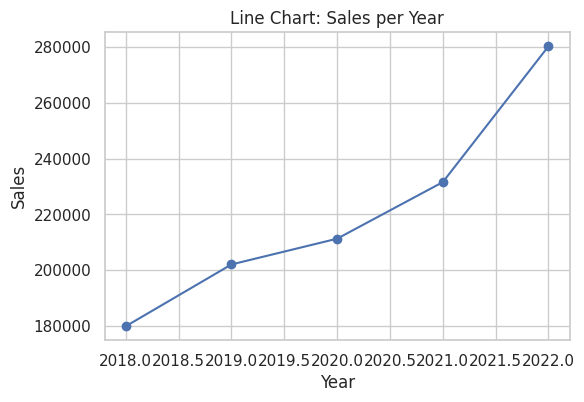

In [15]:
plt.figure(figsize=(6,4))
plt.plot(yearly['year'], yearly['sales'], marker='o')
plt.title('Line Chart: Sales per Year')
plt.xlabel('Year'); plt.ylabel('Sales')
plt.grid(True); plt.show()

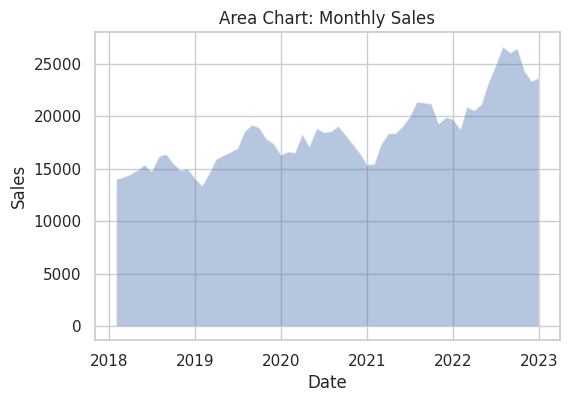

In [16]:
plt.figure(figsize=(6,4))
plt.fill_between(monthly['date'], monthly['sales'], alpha=0.4)
plt.title('Area Chart: Monthly Sales'); plt.xlabel('Date'); plt.ylabel('Sales')
plt.show()

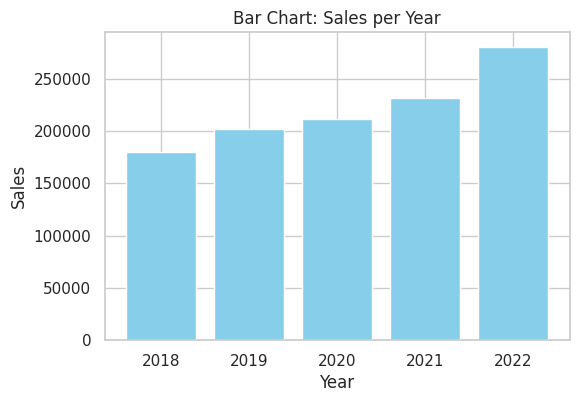

In [17]:
plt.figure(figsize=(6,4))
plt.bar(yearly['year'], yearly['sales'], color='skyblue')
plt.title('Bar Chart: Sales per Year'); plt.xlabel('Year'); plt.ylabel('Sales')
plt.show()

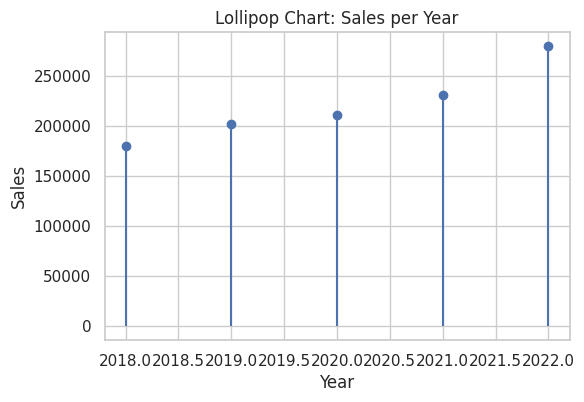

In [18]:
plt.figure(figsize=(6,4))
plt.stem(yearly['year'], yearly['sales'], basefmt=" ")
plt.title('Lollipop Chart: Sales per Year'); plt.xlabel('Year'); plt.ylabel('Sales')
plt.show()

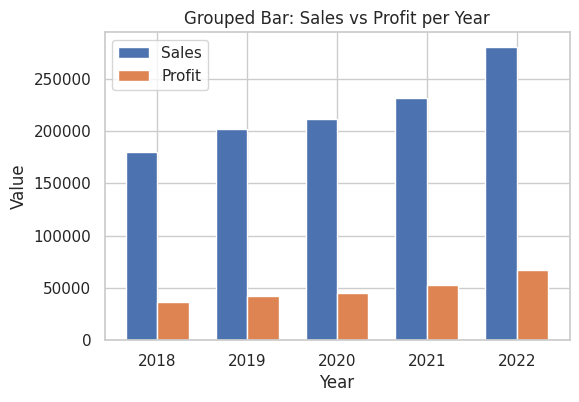

In [19]:
# 5) Grouped Bar Chart
plt.figure(figsize=(6,4))
x = np.arange(len(yearly))
bar_w = 0.35
plt.bar(x-bar_w/2, yearly['sales'], bar_w, label='Sales')
plt.bar(x+bar_w/2, yearly['profit'], bar_w, label='Profit')
plt.xticks(x, yearly['year'])
plt.title('Grouped Bar: Sales vs Profit per Year')
plt.xlabel('Year'); plt.ylabel('Value'); plt.legend()
plt.show()

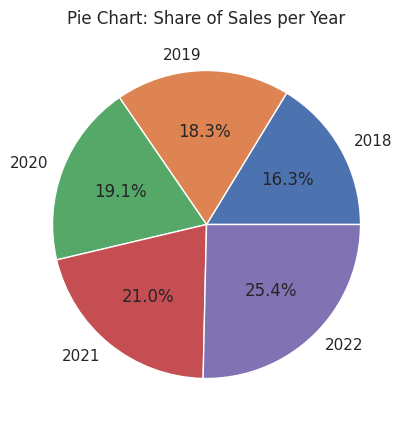

In [20]:
# 6) Pie Chart
plt.figure(figsize=(5,5))
plt.pie(yearly['sales'], labels=yearly['year'], autopct='%1.1f%%')
plt.title('Pie Chart: Share of Sales per Year'); plt.show()



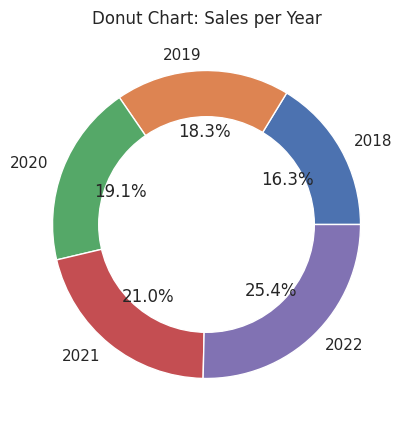

In [21]:
# 7) Donut Chart
plt.figure(figsize=(5,5))
wedges, texts, autotexts = plt.pie(yearly['sales'], labels=yearly['year'], autopct='%1.1f%%')
centre_circle = plt.Circle((0,0),0.70,fc='white')
plt.gca().add_artist(centre_circle)
plt.title('Donut Chart: Sales per Year'); plt.show()



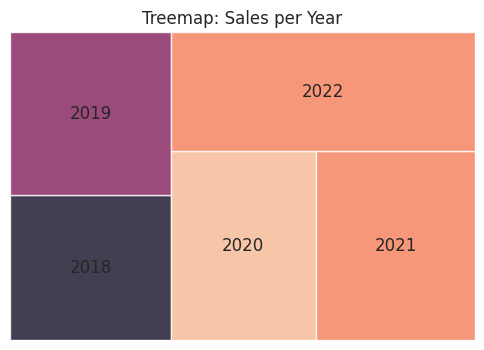

In [22]:
# 8) Treemap
plt.figure(figsize=(6,4))
squarify.plot(sizes=yearly['sales'], label=yearly['year'], alpha=.8)
plt.title('Treemap: Sales per Year'); plt.axis('off'); plt.show()



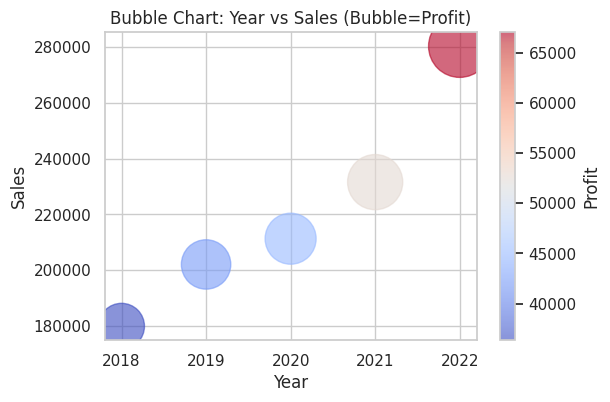

In [23]:
# 9) Bubble Chart
plt.figure(figsize=(6,4))
plt.scatter(yearly['year'], yearly['sales'], s=yearly['profit']*0.03, alpha=0.6, c=yearly['profit'], cmap='coolwarm')
plt.title('Bubble Chart: Year vs Sales (Bubble=Profit)')
plt.xlabel('Year'); plt.ylabel('Sales'); plt.colorbar(label='Profit')
plt.show()



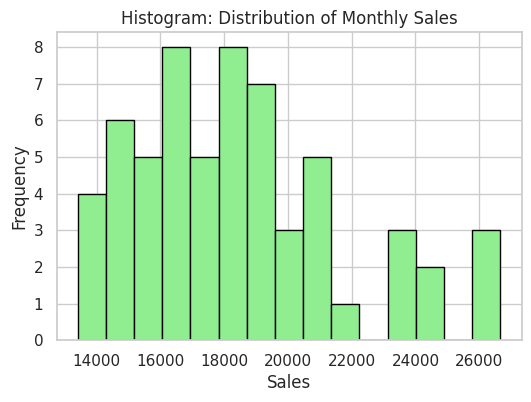

In [24]:
# 10) Histogram
plt.figure(figsize=(6,4))
plt.hist(monthly['sales'], bins=15, edgecolor='black', color='lightgreen')
plt.title('Histogram: Distribution of Monthly Sales'); plt.xlabel('Sales'); plt.ylabel('Frequency')
plt.show()



/tmp/ipython-input-1921624342.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=region_month, x='region', y='sales', palette='Set2')


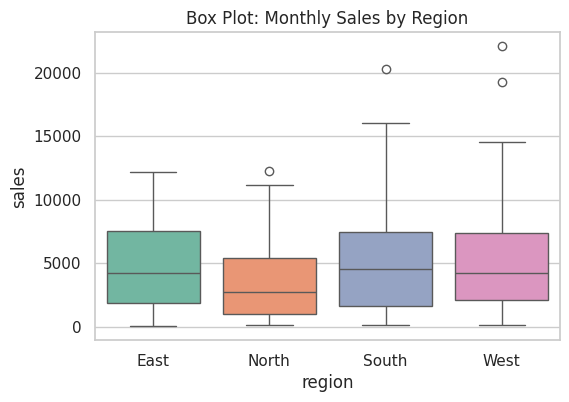

In [25]:
# 11) Box Plot
plt.figure(figsize=(6,4))
sns.boxplot(data=region_month, x='region', y='sales', palette='Set2')
plt.title('Box Plot: Monthly Sales by Region'); plt.show()



/tmp/ipython-input-3028350802.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=region_month, x='region', y='sales', palette='muted')


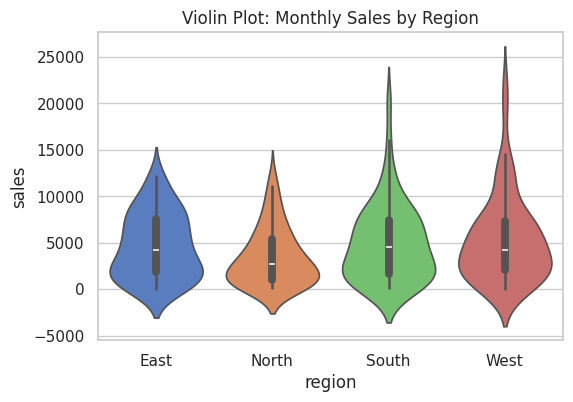

In [26]:
# 12) Violin Plot
plt.figure(figsize=(6,4))
sns.violinplot(data=region_month, x='region', y='sales', palette='muted')
plt.title('Violin Plot: Monthly Sales by Region'); plt.show()


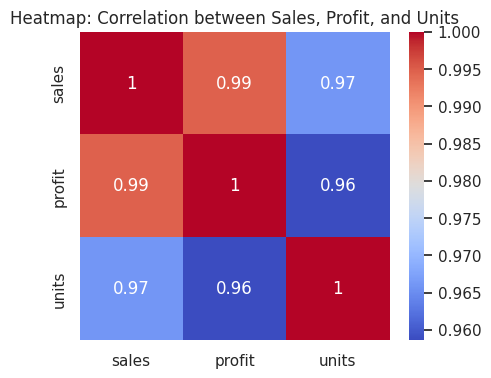

In [27]:

# 13) Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(fact[['sales','profit','units']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap: Correlation between Sales, Profit, and Units'); plt.show()



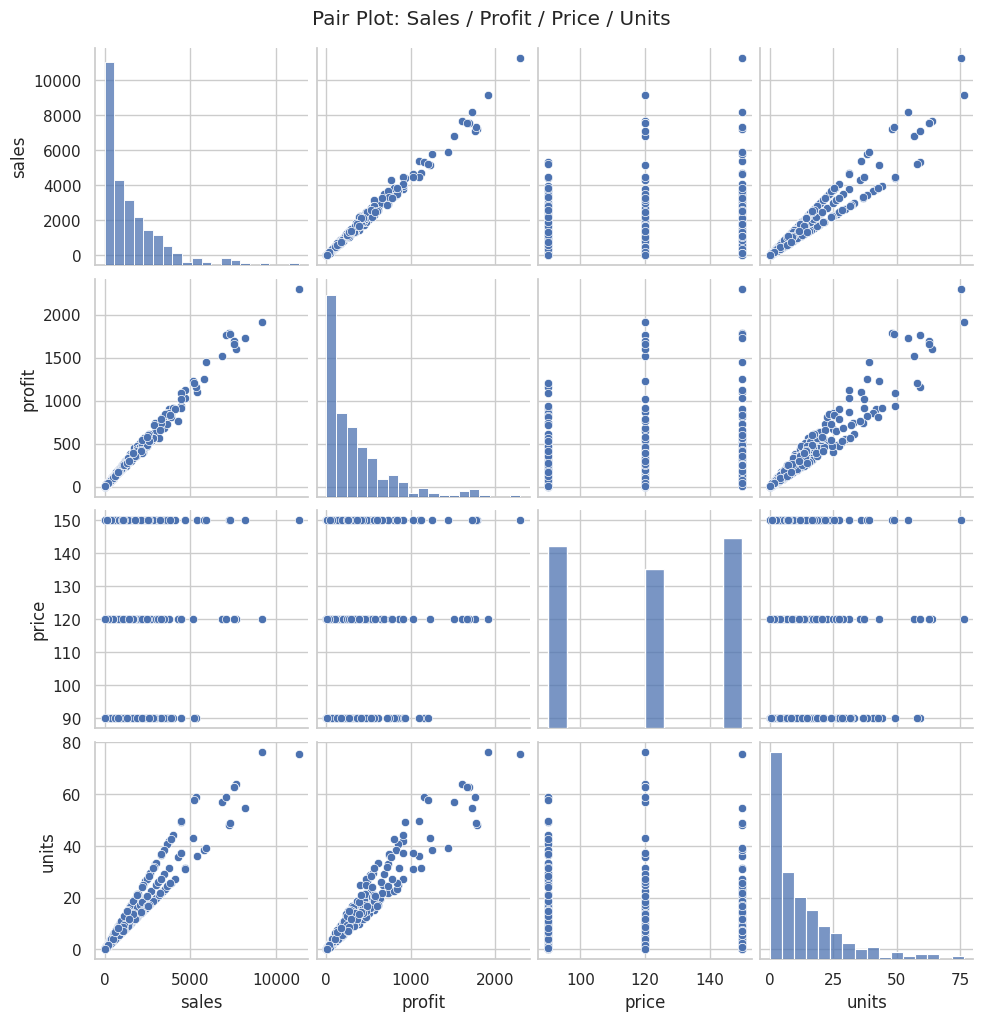

In [28]:
# 14) Pair Plot
sns.pairplot(fact[['sales','profit','price','units']].sample(300))
plt.suptitle('Pair Plot: Sales / Profit / Price / Units', y=1.02)
plt.show()



/tmp/ipython-input-1025868373.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=prod_month, x='product', y='sales', size=5, palette='pastel')


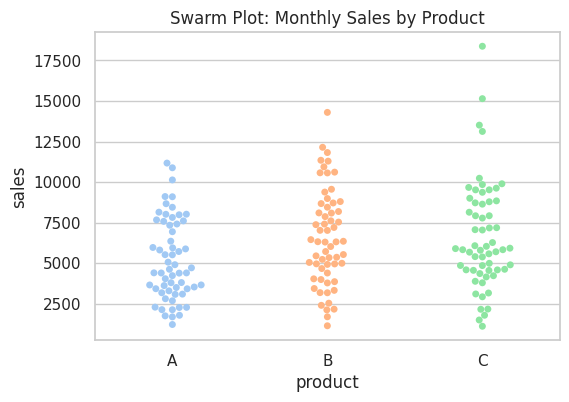

In [29]:
# 15) Swarm Plot
prod_month = fact.groupby(['date','product'], as_index=False)['sales'].sum()
plt.figure(figsize=(6,4))
sns.swarmplot(data=prod_month, x='product', y='sales', size=5, palette='pastel')
plt.title('Swarm Plot: Monthly Sales by Product'); plt.show()



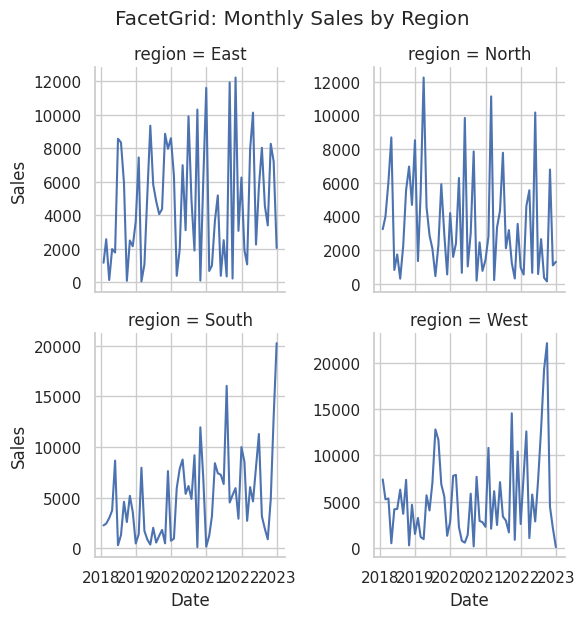

In [30]:
# 16) FacetGrid
g = sns.FacetGrid(region_month, col='region', col_wrap=2, height=3, sharey=False)
g.map_dataframe(sns.lineplot, x='date', y='sales')
g.set_axis_labels('Date','Sales')
g.fig.suptitle('FacetGrid: Monthly Sales by Region', y=1.03)
plt.show()



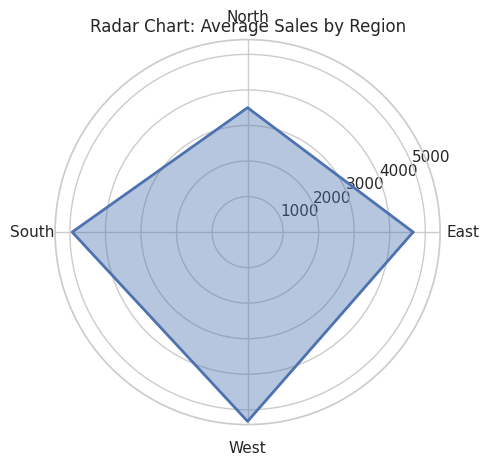

In [31]:
# 17) Radar Chart
region_mean = region_month.groupby('region', as_index=False)['sales'].mean()
categories = region_mean['region']
values = region_mean['sales'].tolist()
values += values[:1]
angles = [n/float(len(categories))*2*pi for n in range(len(categories))]
angles += angles[:1]
plt.figure(figsize=(5,5))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories)
ax.plot(angles, values, linewidth=2)
ax.fill(angles, values, alpha=0.4)
plt.title('Radar Chart: Average Sales by Region')
plt.show()



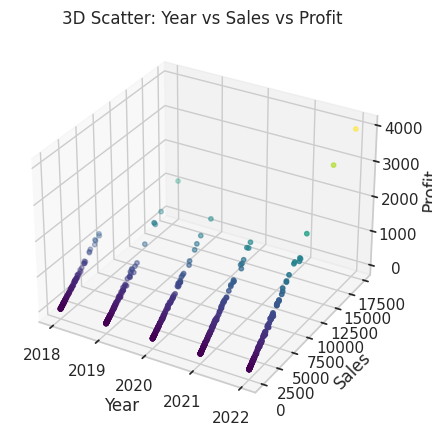

In [32]:
# 18) 3D Scatter
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fact['year'], fact['sales'], fact['profit'], c=fact['profit'], cmap='viridis', s=10)
ax.set_xlabel('Year'); ax.set_ylabel('Sales'); ax.set_zlabel('Profit')
plt.title('3D Scatter: Year vs Sales vs Profit')
plt.show()